# Advantage Actor Critic (A2C) Method

Advantage Actor-Critic (A2C) is a reinforcement learning algorithm that combines elements from policy gradient methods (like REINFORCE) and value-based methods (like Q-learning). The A2C algorithm aims to learn an optimal policy by iteratively improving the actor and critic networks.

#### Requirements  

gym==0.22.0
<br> torch==1.13.1
<br> seaborn==0.12.2
<br> pandas==1.3.5
<br> tqdm

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [2]:
torch.__version__

'1.13.1'

### Define the Actor network

In [3]:
class Actor(nn.Module):

    def __init__(self, state_dim,  action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)

    def forward(self, state):
        x1 = F.relu(self.fc1(state))
        x2 = F.relu(self.fc2(x1))
        action_probs = F.softmax(self.fc3(x2), dim=-1)
        return action_probs

### Define the Critic network

In [4]:
class Critic(nn.Module):

    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state):
        x1 = F.relu(self.fc1(state))
        x2 = F.relu(self.fc2(x1))
        value = self.fc3(x2)
        return value

### Create the CartPole-v1 environment

In [5]:
env = gym.make("CartPole-v1")
env.seed(0)

state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

### Configure A2C

In [6]:
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99

### Training

In [7]:
episode_rewards = []
num_episodes=500

stats={'actor loss':[], 'critic loss':[], 'return':[]}

# Initialize tqdm progress bar
pbar = tqdm(total=num_episodes, ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')

for episode in range(num_episodes):
    done = False
    total_reward = 0
    state = env.reset()
    env.seed(0)

    while not done:
        
        probs = actor(torch.from_numpy(state).float())
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())

        # Compute the advantage function
        advantage = reward + (1-done)*gamma*critic(torch.from_numpy(next_state).float()) - critic(torch.from_numpy(state).float())        

        # Update the reward and the state                   
        total_reward += reward
        state = next_state

        # Calculate the critic and the actor losses
        critic_loss = advantage.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()

        actor_loss = -dist.log_prob(action)*advantage.detach()
        
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()
        
    stats['actor loss'].append(actor_loss)
    stats['critic loss'].append(critic_loss)
    stats['return'].append(total_reward)
    print('Actor loss= ', round(stats['actor loss'][episode].item(), 4), 'Critic loss= ', round(stats['critic loss'][episode].item(), 4), 'Return= ', stats['return'][episode])

    # Update tqdm progress bar
    pbar.set_description(f"Episode {episode + 1}")
    pbar.set_postfix({"Reward": episode_rewards})
    pbar.update(1)
            
    episode_rewards.append(total_reward)

# Close tqdm progress bar
pbar.close()

Episode 1:   0%|                                                         | 1/500

Actor loss=  0.832 Critic loss=  1.0937 Return=  33.0


Episode 2:   0%|▏                                                        | 2/500

Actor loss=  1.0733 Critic loss=  1.1862 Return=  30.0


Episode 4:   1%|▎                                                        | 3/500

Actor loss=  0.7468 Critic loss=  1.1296 Return=  27.0
Actor loss=  0.9243 Critic loss=  1.0876 Return=  24.0


Episode 6:   1%|▋                                                        | 6/500

Actor loss=  1.1693 Critic loss=  1.1436 Return=  33.0
Actor loss=  0.479 Critic loss=  0.9696 Return=  19.0


Episode 8:   2%|▉                                                        | 8/500

Actor loss=  0.4647 Critic loss=  0.8976 Return=  30.0
Actor loss=  0.4364 Critic loss=  0.8821 Return=  21.0


Episode 9:   2%|█                                                        | 9/500

Actor loss=  0.3445 Critic loss=  0.8943 Return=  13.0


Episode 10:   2%|█                                                      | 10/500

Actor loss=  0.2602 Critic loss=  0.8018 Return=  16.0


Episode 11:   2%|█▏                                                     | 11/500

Actor loss=  0.389 Critic loss=  0.6675 Return=  31.0


Episode 13:   3%|█▍                                                     | 13/500

Actor loss=  0.3678 Critic loss=  0.6977 Return=  18.0
Actor loss=  0.9285 Critic loss=  0.6854 Return=  14.0


Episode 15:   3%|█▌                                                     | 14/500

Actor loss=  0.3106 Critic loss=  0.6618 Return=  16.0
Actor loss=  0.3109 Critic loss=  0.5081 Return=  23.0


Episode 17:   3%|█▊                                                     | 17/500

Actor loss=  0.6898 Critic loss=  0.5246 Return=  18.0
Actor loss=  0.5982 Critic loss=  0.4616 Return=  23.0


Episode 19:   4%|██                                                     | 19/500

Actor loss=  0.3749 Critic loss=  0.3959 Return=  24.0
Actor loss=  0.4105 Critic loss=  0.3957 Return=  18.0


Episode 21:   4%|██▎                                                    | 21/500

Actor loss=  0.3738 Critic loss=  0.3986 Return=  12.0
Actor loss=  0.3031 Critic loss=  0.3338 Return=  13.0


Episode 23:   5%|██▌                                                    | 23/500

Actor loss=  0.5084 Critic loss=  0.3094 Return=  13.0
Actor loss=  0.4122 Critic loss=  0.3382 Return=  17.0


Episode 25:   5%|██▊                                                    | 25/500

Actor loss=  0.329 Critic loss=  0.2602 Return=  18.0
Actor loss=  0.2993 Critic loss=  0.2514 Return=  16.0


Episode 27:   5%|██▉                                                    | 27/500

Actor loss=  0.4237 Critic loss=  0.3363 Return=  22.0
Actor loss=  0.3107 Critic loss=  0.1311 Return=  15.0


Episode 29:   6%|███                                                    | 28/500

Actor loss=  0.2676 Critic loss=  0.1208 Return=  17.0
Actor loss=  0.2803 Critic loss=  0.1396 Return=  18.0


Episode 32:   6%|███▍                                                   | 31/500

Actor loss=  0.456 Critic loss=  0.2868 Return=  23.0
Actor loss=  0.2933 Critic loss=  0.1952 Return=  13.0
Actor loss=  0.3309 Critic loss=  0.2069 Return=  11.0


Episode 34:   7%|███▋                                                   | 34/500

Actor loss=  0.4126 Critic loss=  0.3353 Return=  16.0
Actor loss=  0.0283 Critic loss=  0.0031 Return=  13.0


Episode 36:   7%|███▉                                                   | 36/500

Actor loss=  0.0138 Critic loss=  0.0005 Return=  15.0
Actor loss=  -0.0875 Critic loss=  0.0261 Return=  16.0


Episode 37:   7%|████                                                   | 37/500

Actor loss=  0.0601 Critic loss=  0.005 Return=  21.0


Episode 39:   8%|████▎                                                  | 39/500

Actor loss=  -0.094 Critic loss=  0.0108 Return=  30.0
Actor loss=  0.1206 Critic loss=  0.0752 Return=  19.0


Episode 41:   8%|████▍                                                  | 40/500

Actor loss=  -0.3839 Critic loss=  0.2605 Return=  15.0
Actor loss=  -0.3793 Critic loss=  0.2564 Return=  24.0


Episode 42:   8%|████▌                                                  | 42/500

Actor loss=  0.0272 Critic loss=  0.0046 Return=  30.0


Episode 43:   9%|████▋                                                  | 43/500

Actor loss=  -0.307 Critic loss=  0.2657 Return=  46.0


Episode 45:   9%|████▉                                                  | 45/500

Actor loss=  -0.9368 Critic loss=  3.4461 Return=  35.0
Actor loss=  -0.6392 Critic loss=  3.5312 Return=  12.0


Episode 47:   9%|█████▏                                                 | 47/500

Actor loss=  -0.7267 Critic loss=  0.5002 Return=  31.0
Actor loss=  -0.7664 Critic loss=  0.6669 Return=  22.0


Episode 48:   9%|█████▏                                                 | 47/500

Actor loss=  -0.0934 Critic loss=  0.0527 Return=  9.0


Episode 50:  10%|█████▌                                                 | 50/500

Actor loss=  -0.551 Critic loss=  0.2427 Return=  55.0
Actor loss=  -0.0238 Critic loss=  0.0074 Return=  16.0


Episode 51:  10%|█████▌                                                 | 51/500

Actor loss=  0.5261 Critic loss=  1.347 Return=  94.0


Episode 52:  10%|█████▋                                                 | 52/500

Actor loss=  -0.0652 Critic loss=  0.1462 Return=  69.0


Episode 53:  11%|█████▊                                                 | 53/500

Actor loss=  -0.5409 Critic loss=  1.641 Return=  29.0


Episode 55:  11%|█████▉                                                 | 54/500

Actor loss=  -0.4203 Critic loss=  1.1501 Return=  22.0
Actor loss=  -0.4547 Critic loss=  0.8565 Return=  24.0


Episode 56:  11%|██████▏                                                | 56/500

Actor loss=  -0.3035 Critic loss=  0.4187 Return=  40.0


Episode 57:  11%|██████▎                                                | 57/500

Actor loss=  -0.0892 Critic loss=  0.0544 Return=  49.0


Episode 58:  12%|██████▍                                                | 58/500

Actor loss=  0.2078 Critic loss=  0.4228 Return=  91.0


Episode 59:  12%|██████▍                                                | 59/500

Actor loss=  0.0491 Critic loss=  0.0121 Return=  63.0


Episode 60:  12%|██████▌                                                | 60/500

Actor loss=  -0.1457 Critic loss=  0.147 Return=  38.0


Episode 61:  12%|██████▋                                                | 61/500

Actor loss=  -0.0946 Critic loss=  0.0023 Return=  75.0


Episode 62:  12%|██████▊                                                | 62/500

Actor loss=  -0.5269 Critic loss=  1.1039 Return=  42.0


Episode 64:  13%|██████▉                                                | 63/500

Actor loss=  -0.0555 Critic loss=  0.3037 Return=  31.0
Actor loss=  -0.2394 Critic loss=  0.725 Return=  23.0


Episode 65:  13%|███████▏                                               | 65/500

Actor loss=  0.1793 Critic loss=  0.1118 Return=  78.0


Episode 66:  13%|███████▎                                               | 66/500

Actor loss=  -0.4237 Critic loss=  0.0455 Return=  37.0


Episode 68:  14%|███████▍                                               | 68/500

Actor loss=  -0.2579 Critic loss=  0.5865 Return=  48.0
Actor loss=  -0.3811 Critic loss=  0.3947 Return=  19.0


Episode 69:  14%|███████▌                                               | 69/500

Actor loss=  -0.3666 Critic loss=  0.2713 Return=  23.0


Episode 70:  14%|███████▋                                               | 70/500

Actor loss=  -0.4415 Critic loss=  0.1611 Return=  45.0


Episode 71:  14%|███████▊                                               | 71/500

Actor loss=  0.1542 Critic loss=  0.1844 Return=  55.0


Episode 72:  14%|███████▉                                               | 72/500

Actor loss=  -0.3066 Critic loss=  0.2912 Return=  91.0


Episode 73:  15%|████████                                               | 73/500

Actor loss=  -0.0051 Critic loss=  0.0058 Return=  65.0


Episode 74:  15%|████████▏                                              | 74/500

Actor loss=  -0.029 Critic loss=  0.3526 Return=  42.0


Episode 75:  15%|████████▎                                              | 75/500

Actor loss=  -0.0674 Critic loss=  0.0319 Return=  38.0


Episode 76:  15%|████████▎                                              | 76/500

Actor loss=  0.021 Critic loss=  0.6164 Return=  76.0


Episode 77:  15%|████████▍                                              | 77/500

Actor loss=  -0.4 Critic loss=  1.0152 Return=  48.0


Episode 78:  16%|████████▌                                              | 78/500

Actor loss=  1.3617 Critic loss=  7.0041 Return=  109.0


Episode 80:  16%|████████▋                                              | 79/500

Actor loss=  -1.1496 Critic loss=  4.4657 Return=  40.0
Actor loss=  -0.4333 Critic loss=  2.119 Return=  24.0


Episode 81:  16%|████████▉                                              | 81/500

Actor loss=  -0.1928 Critic loss=  0.8894 Return=  44.0


Episode 83:  16%|█████████                                              | 82/500

Actor loss=  -0.0563 Critic loss=  0.4297 Return=  44.0
Actor loss=  -0.0504 Critic loss=  0.18 Return=  28.0


Episode 84:  17%|█████████▏                                             | 84/500

Actor loss=  -0.0976 Critic loss=  0.2641 Return=  31.0


Episode 85:  17%|█████████▎                                             | 85/500

Actor loss=  -1.1256 Critic loss=  1.0089 Return=  53.0


Episode 86:  17%|█████████▍                                             | 86/500

Actor loss=  -0.2116 Critic loss=  0.4757 Return=  60.0


Episode 87:  17%|█████████▌                                             | 87/500

Actor loss=  2.7277 Critic loss=  2.8849 Return=  173.0


Episode 88:  18%|█████████▋                                             | 88/500

Actor loss=  -0.168 Critic loss=  1.6743 Return=  59.0


Episode 89:  18%|█████████▊                                             | 89/500

Actor loss=  -0.0684 Critic loss=  0.2871 Return=  73.0


Episode 90:  18%|█████████▉                                             | 90/500

Actor loss=  -0.2376 Critic loss=  1.3636 Return=  42.0


Episode 91:  18%|██████████                                             | 91/500

Actor loss=  -1.7466 Critic loss=  0.8851 Return=  40.0


Episode 92:  18%|██████████                                             | 92/500

Actor loss=  -0.6823 Critic loss=  0.8544 Return=  48.0


Episode 93:  19%|██████████▏                                            | 93/500

Actor loss=  0.1192 Critic loss=  1.194 Return=  110.0


Episode 94:  19%|██████████▎                                            | 94/500

Actor loss=  -0.2015 Critic loss=  1.4749 Return=  64.0


Episode 95:  19%|██████████▍                                            | 95/500

Actor loss=  -1.5294 Critic loss=  0.7548 Return=  105.0


Episode 96:  19%|██████████▌                                            | 96/500

Actor loss=  -2.1385 Critic loss=  1.3729 Return=  56.0


Episode 97:  19%|██████████▋                                            | 97/500

Actor loss=  -0.3098 Critic loss=  3.7789 Return=  94.0


Episode 98:  20%|██████████▊                                            | 98/500

Actor loss=  -0.0787 Critic loss=  0.2044 Return=  106.0


Episode 99:  20%|██████████▉                                            | 99/500

Actor loss=  -0.0598 Critic loss=  0.1714 Return=  79.0


Episode 100:  20%|██████████▌                                          | 100/500

Actor loss=  -0.018 Critic loss=  0.0306 Return=  90.0


Episode 101:  20%|██████████▋                                          | 101/500

Actor loss=  -1.0389 Critic loss=  51.5805 Return=  177.0


Episode 102:  20%|██████████▊                                          | 102/500

Actor loss=  -2.881 Critic loss=  20.1109 Return=  28.0


Episode 103:  21%|██████████▉                                          | 103/500

Actor loss=  -0.7029 Critic loss=  5.9766 Return=  36.0


Episode 104:  21%|███████████                                          | 104/500

Actor loss=  -0.1496 Critic loss=  2.4358 Return=  35.0


Episode 106:  21%|███████████▏                                         | 106/500

Actor loss=  0.0505 Critic loss=  0.084 Return=  50.0
Actor loss=  -2.0444 Critic loss=  4.6414 Return=  23.0


Episode 107:  21%|███████████▎                                         | 107/500

Actor loss=  -0.2605 Critic loss=  0.0671 Return=  34.0


Episode 108:  22%|███████████▍                                         | 108/500

Actor loss=  0.341 Critic loss=  0.3355 Return=  39.0


Episode 109:  22%|███████████▌                                         | 109/500

Actor loss=  -0.0191 Critic loss=  1.2262 Return=  29.0


Episode 110:  22%|███████████▋                                         | 110/500

Actor loss=  -0.0038 Critic loss=  0.0071 Return=  32.0


Episode 111:  22%|███████████▊                                         | 111/500

Actor loss=  2.6951 Critic loss=  3.1791 Return=  40.0


Episode 112:  22%|███████████▊                                         | 112/500

Actor loss=  1.3484 Critic loss=  40.4018 Return=  85.0


Episode 113:  23%|███████████▉                                         | 113/500

Actor loss=  0.0381 Critic loss=  0.0199 Return=  64.0


Episode 114:  23%|████████████                                         | 114/500

Actor loss=  -3.8717 Critic loss=  9.5334 Return=  237.0


Episode 115:  23%|████████████▏                                        | 115/500

Actor loss=  2.4972 Critic loss=  26.0253 Return=  172.0


Episode 116:  23%|████████████▎                                        | 116/500

Actor loss=  0.3259 Critic loss=  1.1952 Return=  237.0


Episode 117:  23%|████████████▍                                        | 117/500

Actor loss=  0.1407 Critic loss=  1.2966 Return=  79.0


Episode 118:  24%|████████████▌                                        | 118/500

Actor loss=  -5.3055 Critic loss=  56.4854 Return=  219.0


Episode 119:  24%|████████████▌                                        | 119/500

Actor loss=  0.418 Critic loss=  8.6515 Return=  199.0


Episode 120:  24%|████████████▋                                        | 120/500

Actor loss=  4.1386 Critic loss=  9.0453 Return=  138.0


Episode 121:  24%|████████████▊                                        | 121/500

Actor loss=  0.0515 Critic loss=  0.3759 Return=  109.0


Episode 122:  24%|████████████▉                                        | 122/500

Actor loss=  0.078 Critic loss=  0.035 Return=  119.0


Episode 123:  25%|█████████████                                        | 123/500

Actor loss=  -0.0134 Critic loss=  0.014 Return=  104.0


Episode 124:  25%|█████████████▏                                       | 124/500

Actor loss=  -0.0538 Critic loss=  0.5363 Return=  96.0


Episode 125:  25%|█████████████▎                                       | 125/500

Actor loss=  -0.0491 Critic loss=  0.4308 Return=  75.0


Episode 126:  25%|█████████████▎                                       | 126/500

Actor loss=  -0.0478 Critic loss=  0.2083 Return=  59.0


Episode 127:  25%|█████████████▍                                       | 127/500

Actor loss=  -0.0358 Critic loss=  0.0767 Return=  53.0


Episode 128:  26%|█████████████▌                                       | 128/500

Actor loss=  -0.027 Critic loss=  0.5545 Return=  61.0


Episode 129:  26%|█████████████▋                                       | 129/500

Actor loss=  0.0127 Critic loss=  0.0523 Return=  254.0


Episode 130:  26%|█████████████▊                                       | 130/500

Actor loss=  -0.0088 Critic loss=  1.7016 Return=  116.0


Episode 131:  26%|█████████████▉                                       | 131/500

Actor loss=  -0.3904 Critic loss=  22.5268 Return=  38.0


Episode 132:  26%|█████████████▉                                       | 132/500

Actor loss=  -0.7631 Critic loss=  8.6939 Return=  36.0


Episode 133:  27%|██████████████                                       | 133/500

Actor loss=  -0.1421 Critic loss=  3.9999 Return=  31.0


Episode 135:  27%|██████████████▏                                      | 134/500

Actor loss=  -0.0772 Critic loss=  3.2768 Return=  28.0
Actor loss=  -0.0913 Critic loss=  0.4736 Return=  27.0


Episode 137:  27%|██████████████▌                                      | 137/500

Actor loss=  -0.227 Critic loss=  2.2232 Return=  20.0
Actor loss=  -0.4551 Critic loss=  1.5274 Return=  20.0


Episode 139:  28%|██████████████▋                                      | 139/500

Actor loss=  -0.0454 Critic loss=  0.867 Return=  18.0
Actor loss=  -0.2988 Critic loss=  0.855 Return=  15.0


Episode 140:  28%|██████████████▊                                      | 140/500

Actor loss=  -0.0528 Critic loss=  0.034 Return=  17.0


Episode 142:  28%|██████████████▉                                      | 141/500

Actor loss=  0.1764 Critic loss=  0.3827 Return=  21.0
Actor loss=  0.058 Critic loss=  0.9966 Return=  26.0


Episode 144:  29%|███████████████▎                                     | 144/500

Actor loss=  -0.0036 Critic loss=  0.011 Return=  21.0
Actor loss=  0.0003 Critic loss=  0.0 Return=  21.0


Episode 146:  29%|███████████████▍                                     | 146/500

Actor loss=  -0.0543 Critic loss=  0.1618 Return=  19.0
Actor loss=  -0.0501 Critic loss=  0.2645 Return=  16.0


Episode 148:  30%|███████████████▋                                     | 148/500

Actor loss=  0.0486 Critic loss=  0.0736 Return=  19.0
Actor loss=  0.7012 Critic loss=  0.3664 Return=  20.0


Episode 150:  30%|███████████████▉                                     | 150/500

Actor loss=  -0.0272 Critic loss=  0.058 Return=  19.0
Actor loss=  0.0858 Critic loss=  0.023 Return=  20.0


Episode 151:  30%|████████████████                                     | 151/500

Actor loss=  -0.0435 Critic loss=  0.3121 Return=  16.0


Episode 153:  30%|████████████████                                     | 152/500

Actor loss=  0.2986 Critic loss=  0.8198 Return=  22.0
Actor loss=  0.0542 Critic loss=  0.021 Return=  20.0


Episode 155:  31%|████████████████▎                                    | 154/500

Actor loss=  0.084 Critic loss=  0.8065 Return=  24.0
Actor loss=  0.7349 Critic loss=  0.5191 Return=  27.0


Episode 157:  31%|████████████████▌                                    | 156/500

Actor loss=  0.0163 Critic loss=  0.4183 Return=  30.0
Actor loss=  -0.8326 Critic loss=  0.1345 Return=  26.0


Episode 159:  32%|████████████████▊                                    | 159/500

Actor loss=  0.0165 Critic loss=  0.2202 Return=  28.0
Actor loss=  -0.2662 Critic loss=  0.6045 Return=  23.0


Episode 160:  32%|████████████████▉                                    | 160/500

Actor loss=  0.09 Critic loss=  4.4137 Return=  33.0


Episode 161:  32%|█████████████████                                    | 161/500

Actor loss=  0.015 Critic loss=  2.7022 Return=  39.0


Episode 162:  32%|█████████████████▏                                   | 162/500

Actor loss=  5.0967 Critic loss=  10.4594 Return=  50.0


Episode 164:  33%|█████████████████▎                                   | 163/500

Actor loss=  -1.7697 Critic loss=  2.7647 Return=  32.0
Actor loss=  -3.143 Critic loss=  4.2329 Return=  27.0


Episode 165:  33%|█████████████████▍                                   | 165/500

Actor loss=  0.0051 Critic loss=  0.0359 Return=  33.0


Episode 166:  33%|█████████████████▌                                   | 166/500

Actor loss=  -0.2524 Critic loss=  0.4388 Return=  28.0


Episode 167:  33%|█████████████████▋                                   | 167/500

Actor loss=  0.1249 Critic loss=  2.8833 Return=  36.0


Episode 168:  34%|█████████████████▊                                   | 168/500

Actor loss=  0.4635 Critic loss=  10.6658 Return=  54.0


Episode 169:  34%|█████████████████▉                                   | 169/500

Actor loss=  0.0193 Critic loss=  1.3011 Return=  55.0


Episode 170:  34%|██████████████████                                   | 170/500

Actor loss=  0.008 Critic loss=  0.7362 Return=  53.0


Episode 171:  34%|██████████████████▏                                  | 171/500

Actor loss=  2.0245 Critic loss=  0.7368 Return=  52.0


Episode 172:  34%|██████████████████▏                                  | 172/500

Actor loss=  0.0015 Critic loss=  0.0034 Return=  53.0


Episode 173:  35%|██████████████████▎                                  | 173/500

Actor loss=  -0.0379 Critic loss=  0.0055 Return=  48.0


Episode 174:  35%|██████████████████▍                                  | 174/500

Actor loss=  0.0327 Critic loss=  2.2834 Return=  56.0


Episode 175:  35%|██████████████████▌                                  | 175/500

Actor loss=  0.6231 Critic loss=  4.0406 Return=  68.0


Episode 176:  35%|██████████████████▋                                  | 176/500

Actor loss=  0.1195 Critic loss=  1.0048 Return=  70.0


Episode 177:  35%|██████████████████▊                                  | 177/500

Actor loss=  0.0618 Critic loss=  0.0115 Return=  80.0


Episode 178:  36%|██████████████████▊                                  | 178/500

Actor loss=  -0.001 Critic loss=  1.0457 Return=  69.0


Episode 179:  36%|██████████████████▉                                  | 179/500

Actor loss=  -0.0041 Critic loss=  0.9148 Return=  55.0


Episode 180:  36%|███████████████████                                  | 180/500

Actor loss=  -0.9393 Critic loss=  1.5497 Return=  48.0


Episode 181:  36%|███████████████████▏                                 | 181/500

Actor loss=  0.1346 Critic loss=  1.7908 Return=  54.0


Episode 183:  36%|███████████████████▎                                 | 182/500

Actor loss=  -0.0148 Critic loss=  12.3982 Return=  37.0
Actor loss=  -1.126 Critic loss=  15.3303 Return=  23.0


Episode 185:  37%|███████████████████▌                                 | 185/500

Actor loss=  -0.4186 Critic loss=  6.7356 Return=  22.0
Actor loss=  -0.2167 Critic loss=  1.3097 Return=  22.0


Episode 187:  37%|███████████████████▋                                 | 186/500

Actor loss=  -0.0282 Critic loss=  3.3697 Return=  17.0
Actor loss=  0.0169 Critic loss=  0.0027 Return=  21.0


Episode 189:  38%|███████████████████▉                                 | 188/500

Actor loss=  0.0934 Critic loss=  2.8947 Return=  26.0
Actor loss=  -2.6073 Critic loss=  0.7824 Return=  19.0


Episode 191:  38%|████████████████████▏                                | 190/500

Actor loss=  0.3756 Critic loss=  0.262 Return=  25.0
Actor loss=  0.0319 Critic loss=  0.2365 Return=  24.0


Episode 192:  38%|████████████████████▎                                | 192/500

Actor loss=  0.0865 Critic loss=  5.9127 Return=  33.0


Episode 193:  39%|████████████████████▍                                | 193/500

Actor loss=  3.6504 Critic loss=  17.7027 Return=  44.0


Episode 194:  39%|████████████████████▌                                | 194/500

Actor loss=  1.7204 Critic loss=  38.7534 Return=  61.0


Episode 195:  39%|████████████████████▋                                | 195/500

Actor loss=  0.5374 Critic loss=  28.8262 Return=  170.0


Episode 196:  39%|████████████████████▊                                | 196/500

Actor loss=  0.0336 Critic loss=  4.2166 Return=  160.0


Episode 197:  39%|████████████████████▉                                | 197/500

Actor loss=  -0.0926 Critic loss=  5.3371 Return=  86.0


Episode 198:  40%|████████████████████▉                                | 198/500

Actor loss=  -0.2205 Critic loss=  19.7077 Return=  42.0


Episode 199:  40%|█████████████████████                                | 199/500

Actor loss=  -0.0764 Critic loss=  6.5829 Return=  35.0


Episode 200:  40%|█████████████████████▏                               | 200/500

Actor loss=  0.5884 Critic loss=  0.0773 Return=  44.0


Episode 201:  40%|█████████████████████▎                               | 201/500

Actor loss=  0.0236 Critic loss=  0.2534 Return=  64.0


Episode 202:  40%|█████████████████████▍                               | 202/500

Actor loss=  0.1024 Critic loss=  19.7371 Return=  125.0


Episode 203:  41%|█████████████████████▌                               | 203/500

Actor loss=  0.7516 Critic loss=  11.0574 Return=  154.0


Episode 204:  41%|█████████████████████▌                               | 204/500

Actor loss=  -7.3464 Critic loss=  200.3187 Return=  313.0


Episode 205:  41%|█████████████████████▋                               | 205/500

Actor loss=  -0.1158 Critic loss=  73.3092 Return=  160.0


Episode 206:  41%|█████████████████████▊                               | 206/500

Actor loss=  -1.3518 Critic loss=  86.9715 Return=  500.0


Episode 207:  41%|█████████████████████▉                               | 207/500

Actor loss=  -0.0512 Critic loss=  70.5574 Return=  127.0


Episode 208:  42%|██████████████████████                               | 208/500

Actor loss=  0.0358 Critic loss=  0.0052 Return=  445.0


Episode 209:  42%|██████████████████████▏                              | 209/500

Actor loss=  -0.2781 Critic loss=  20.386 Return=  401.0


Episode 210:  42%|██████████████████████▎                              | 210/500

Actor loss=  -0.1446 Critic loss=  1.0857 Return=  247.0


Episode 211:  42%|██████████████████████▎                              | 211/500

Actor loss=  -0.1034 Critic loss=  1.447 Return=  283.0


Episode 212:  42%|██████████████████████▍                              | 212/500

Actor loss=  -0.0702 Critic loss=  0.0869 Return=  106.0


Episode 213:  43%|██████████████████████▌                              | 213/500

Actor loss=  11.5085 Critic loss=  29.1034 Return=  268.0


Episode 214:  43%|██████████████████████▋                              | 214/500

Actor loss=  -11.4709 Critic loss=  160.3095 Return=  500.0


Episode 215:  43%|██████████████████████▊                              | 215/500

Actor loss=  -0.0272 Critic loss=  14.9829 Return=  147.0


Episode 216:  43%|██████████████████████▉                              | 216/500

Actor loss=  0.0718 Critic loss=  0.106 Return=  249.0


Episode 217:  43%|███████████████████████                              | 217/500

Actor loss=  -4.2847 Critic loss=  23.2699 Return=  216.0


Episode 218:  44%|███████████████████████                              | 218/500

Actor loss=  -0.0207 Critic loss=  4.2932 Return=  500.0


Episode 219:  44%|███████████████████████▏                             | 219/500

Actor loss=  -0.7702 Critic loss=  13.8968 Return=  500.0


Episode 220:  44%|███████████████████████▎                             | 220/500

Actor loss=  -8.6831 Critic loss=  21.7018 Return=  500.0


Episode 221:  44%|███████████████████████▍                             | 221/500

Actor loss=  -0.0007 Critic loss=  0.719 Return=  143.0


Episode 222:  44%|███████████████████████▌                             | 222/500

Actor loss=  -0.0065 Critic loss=  5.8364 Return=  276.0


Episode 223:  45%|███████████████████████▋                             | 223/500

Actor loss=  1.2418 Critic loss=  1.5493 Return=  115.0


Episode 224:  45%|███████████████████████▋                             | 224/500

Actor loss=  -0.4424 Critic loss=  44.1539 Return=  52.0


Episode 225:  45%|███████████████████████▊                             | 225/500

Actor loss=  -0.5602 Critic loss=  8.1147 Return=  49.0


Episode 226:  45%|███████████████████████▉                             | 226/500

Actor loss=  -0.0112 Critic loss=  11.9535 Return=  36.0


Episode 227:  45%|████████████████████████                             | 227/500

Actor loss=  -0.0214 Critic loss=  3.6236 Return=  34.0


Episode 228:  46%|████████████████████████▏                            | 228/500

Actor loss=  0.0047 Critic loss=  0.0106 Return=  37.0


Episode 229:  46%|████████████████████████▎                            | 229/500

Actor loss=  -0.2248 Critic loss=  3.3149 Return=  30.0


Episode 230:  46%|████████████████████████▍                            | 230/500

Actor loss=  0.0107 Critic loss=  6.0061 Return=  43.0


Episode 231:  46%|████████████████████████▍                            | 231/500

Actor loss=  0.0022 Critic loss=  8.5752 Return=  48.0


Episode 232:  46%|████████████████████████▌                            | 232/500

Actor loss=  -0.0834 Critic loss=  0.4907 Return=  40.0


Episode 233:  47%|████████████████████████▋                            | 233/500

Actor loss=  -0.0225 Critic loss=  0.0293 Return=  40.0


Episode 234:  47%|████████████████████████▊                            | 234/500

Actor loss=  0.0025 Critic loss=  3.1687 Return=  48.0


Episode 235:  47%|████████████████████████▉                            | 235/500

Actor loss=  0.0008 Critic loss=  0.0273 Return=  46.0


Episode 236:  47%|█████████████████████████                            | 236/500

Actor loss=  -0.0594 Critic loss=  0.0087 Return=  43.0


Episode 237:  47%|█████████████████████████                            | 237/500

Actor loss=  -0.0012 Critic loss=  2.7895 Return=  40.0


Episode 238:  48%|█████████████████████████▏                           | 238/500

Actor loss=  0.0601 Critic loss=  0.101 Return=  40.0


Episode 239:  48%|█████████████████████████▎                           | 239/500

Actor loss=  0.0012 Critic loss=  0.1004 Return=  43.0


Episode 240:  48%|█████████████████████████▍                           | 240/500

Actor loss=  -0.035 Critic loss=  10.9171 Return=  27.0


Episode 241:  48%|█████████████████████████▌                           | 241/500

Actor loss=  -0.1195 Critic loss=  0.8716 Return=  30.0


Episode 243:  48%|█████████████████████████▋                           | 242/500

Actor loss=  -0.0179 Critic loss=  0.7615 Return=  29.0
Actor loss=  -0.0032 Critic loss=  2.2766 Return=  25.0


Episode 244:  49%|█████████████████████████▊                           | 244/500

Actor loss=  0.1012 Critic loss=  4.1744 Return=  34.0


Episode 245:  49%|█████████████████████████▉                           | 245/500

Actor loss=  0.0245 Critic loss=  0.8456 Return=  32.0


Episode 246:  49%|██████████████████████████                           | 246/500

Actor loss=  -0.1165 Critic loss=  3.6031 Return=  25.0


Episode 247:  49%|██████████████████████████▏                          | 247/500

Actor loss=  -1.2325 Critic loss=  0.1661 Return=  27.0


Episode 248:  50%|██████████████████████████▎                          | 248/500

Actor loss=  0.2259 Critic loss=  0.1519 Return=  28.0


Episode 249:  50%|██████████████████████████▍                          | 249/500

Actor loss=  0.0002 Critic loss=  0.0001 Return=  29.0


Episode 251:  50%|██████████████████████████▌                          | 250/500

Actor loss=  0.0068 Critic loss=  1.1325 Return=  31.0
Actor loss=  -0.3701 Critic loss=  3.2565 Return=  23.0


Episode 252:  50%|██████████████████████████▋                          | 252/500

Actor loss=  0.4855 Critic loss=  0.3475 Return=  28.0
Actor loss=  -0.0163 Critic loss=  0.0775 Return=  27.0


Episode 254:  51%|██████████████████████████▉                          | 254/500

Actor loss=  0.282 Critic loss=  0.999 Return=  30.0


Episode 255:  51%|███████████████████████████                          | 255/500

Actor loss=  0.063 Critic loss=  14.6214 Return=  39.0


Episode 256:  51%|███████████████████████████▏                         | 256/500

Actor loss=  -0.006 Critic loss=  0.0042 Return=  37.0


Episode 257:  51%|███████████████████████████▏                         | 257/500

Actor loss=  -0.4813 Critic loss=  0.1053 Return=  35.0


Episode 258:  52%|███████████████████████████▎                         | 258/500

Actor loss=  1.4356 Critic loss=  2.7405 Return=  40.0


Episode 259:  52%|███████████████████████████▍                         | 259/500

Actor loss=  -0.8945 Critic loss=  1.9811 Return=  35.0


Episode 260:  52%|███████████████████████████▌                         | 260/500

Actor loss=  -0.0025 Critic loss=  0.8652 Return=  31.0


Episode 261:  52%|███████████████████████████▋                         | 261/500

Actor loss=  -0.0561 Critic loss=  3.4771 Return=  27.0


Episode 262:  52%|███████████████████████████▊                         | 262/500

Actor loss=  -0.0042 Critic loss=  0.0523 Return=  29.0


Episode 263:  53%|███████████████████████████▉                         | 263/500

Actor loss=  0.0719 Critic loss=  2.0963 Return=  32.0


Episode 264:  53%|███████████████████████████▉                         | 264/500

Actor loss=  -0.0346 Critic loss=  1.9098 Return=  27.0


Episode 265:  53%|████████████████████████████                         | 265/500

Actor loss=  0.1797 Critic loss=  1.6073 Return=  31.0


Episode 266:  53%|████████████████████████████▏                        | 266/500

Actor loss=  0.0141 Critic loss=  0.9644 Return=  36.0


Episode 267:  53%|████████████████████████████▎                        | 267/500

Actor loss=  -0.0389 Critic loss=  0.3099 Return=  30.0


Episode 268:  54%|████████████████████████████▍                        | 268/500

Actor loss=  0.0146 Critic loss=  0.1298 Return=  32.0


Episode 269:  54%|████████████████████████████▌                        | 269/500

Actor loss=  -1.0334 Critic loss=  1.9405 Return=  28.0


Episode 271:  54%|████████████████████████████▌                        | 270/500

Actor loss=  -0.5004 Critic loss=  3.3744 Return=  25.0
Actor loss=  -0.1049 Critic loss=  3.0039 Return=  20.0


Episode 273:  55%|████████████████████████████▉                        | 273/500

Actor loss=  0.0084 Critic loss=  0.0436 Return=  22.0
Actor loss=  -0.0091 Critic loss=  0.0292 Return=  22.0


Episode 275:  55%|█████████████████████████████                        | 274/500

Actor loss=  -0.0389 Critic loss=  0.0005 Return=  21.0
Actor loss=  0.0195 Critic loss=  0.2704 Return=  22.0


Episode 277:  55%|█████████████████████████████▎                       | 277/500

Actor loss=  -0.0403 Critic loss=  0.1762 Return=  20.0
Actor loss=  -0.0238 Critic loss=  0.0473 Return=  21.0


Episode 279:  56%|█████████████████████████████▍                       | 278/500

Actor loss=  0.6303 Critic loss=  0.2883 Return=  23.0
Actor loss=  1.0343 Critic loss=  0.6211 Return=  25.0


Episode 281:  56%|█████████████████████████████▋                       | 280/500

Actor loss=  -3.2603 Critic loss=  2.3355 Return=  20.0
Actor loss=  0.0063 Critic loss=  3.4127 Return=  26.0


Episode 282:  56%|█████████████████████████████▉                       | 282/500

Actor loss=  0.2623 Critic loss=  10.205 Return=  32.0


Episode 283:  57%|█████████████████████████████▉                       | 283/500

Actor loss=  -0.008 Critic loss=  1.0713 Return=  29.0


Episode 284:  57%|██████████████████████████████                       | 284/500

Actor loss=  1.5677 Critic loss=  6.367 Return=  35.0


Episode 285:  57%|██████████████████████████████▏                      | 285/500

Actor loss=  -0.0423 Critic loss=  0.3492 Return=  32.0


Episode 286:  57%|██████████████████████████████▎                      | 286/500

Actor loss=  2.0129 Critic loss=  0.3041 Return=  32.0


Episode 287:  57%|██████████████████████████████▍                      | 287/500

Actor loss=  -0.0052 Critic loss=  0.0042 Return=  30.0


Episode 288:  58%|██████████████████████████████▌                      | 288/500

Actor loss=  -0.0005 Critic loss=  0.0436 Return=  31.0


Episode 289:  58%|██████████████████████████████▋                      | 289/500

Actor loss=  -0.0096 Critic loss=  0.7675 Return=  27.0


Episode 290:  58%|██████████████████████████████▋                      | 290/500

Actor loss=  2.0085 Critic loss=  6.3736 Return=  35.0


Episode 291:  58%|██████████████████████████████▊                      | 291/500

Actor loss=  6.3534 Critic loss=  45.6742 Return=  50.0


Episode 292:  58%|██████████████████████████████▉                      | 292/500

Actor loss=  -0.0114 Critic loss=  24.0681 Return=  31.0


Episode 293:  59%|███████████████████████████████                      | 293/500

Actor loss=  -0.0032 Critic loss=  3.6985 Return=  31.0


Episode 294:  59%|███████████████████████████████▏                     | 294/500

Actor loss=  -0.0368 Critic loss=  0.0834 Return=  31.0


Episode 295:  59%|███████████████████████████████▎                     | 295/500

Actor loss=  4.1839 Critic loss=  8.4505 Return=  40.0


Episode 296:  59%|███████████████████████████████▍                     | 296/500

Actor loss=  0.0133 Critic loss=  84.8141 Return=  68.0


Episode 297:  59%|███████████████████████████████▍                     | 297/500

Actor loss=  0.0017 Critic loss=  12.1666 Return=  68.0


Episode 298:  60%|███████████████████████████████▌                     | 298/500

Actor loss=  0.3542 Critic loss=  5.4121 Return=  109.0


Episode 299:  60%|███████████████████████████████▋                     | 299/500

Actor loss=  -0.1783 Critic loss=  207.8382 Return=  452.0


Episode 300:  60%|███████████████████████████████▊                     | 300/500

Actor loss=  -0.3918 Critic loss=  148.5822 Return=  500.0


Episode 301:  60%|███████████████████████████████▉                     | 301/500

Actor loss=  -0.0082 Critic loss=  13.4918 Return=  155.0


Episode 302:  60%|████████████████████████████████                     | 302/500

Actor loss=  -0.0613 Critic loss=  123.1167 Return=  388.0


Episode 303:  61%|████████████████████████████████                     | 303/500

Actor loss=  -0.2674 Critic loss=  48.269 Return=  500.0


Episode 304:  61%|████████████████████████████████▏                    | 304/500

Actor loss=  -0.0231 Critic loss=  6.9135 Return=  391.0


Episode 305:  61%|████████████████████████████████▎                    | 305/500

Actor loss=  0.0523 Critic loss=  21.2207 Return=  114.0


Episode 306:  61%|████████████████████████████████▍                    | 306/500

Actor loss=  -0.8394 Critic loss=  13.7648 Return=  126.0


Episode 307:  61%|████████████████████████████████▌                    | 307/500

Actor loss=  -0.0133 Critic loss=  0.2893 Return=  287.0


Episode 308:  62%|████████████████████████████████▋                    | 308/500

Actor loss=  0.1067 Critic loss=  21.7517 Return=  98.0


Episode 309:  62%|████████████████████████████████▊                    | 309/500

Actor loss=  -0.0046 Critic loss=  22.2242 Return=  100.0


Episode 310:  62%|████████████████████████████████▊                    | 310/500

Actor loss=  0.0051 Critic loss=  7.5657 Return=  119.0


Episode 311:  62%|████████████████████████████████▉                    | 311/500

Actor loss=  -0.0414 Critic loss=  61.1206 Return=  44.0


Episode 312:  62%|█████████████████████████████████                    | 312/500

Actor loss=  -0.2245 Critic loss=  17.9422 Return=  40.0


Episode 313:  63%|█████████████████████████████████▏                   | 313/500

Actor loss=  -2.166 Critic loss=  8.4017 Return=  38.0


Episode 314:  63%|█████████████████████████████████▎                   | 314/500

Actor loss=  -0.05 Critic loss=  9.9841 Return=  32.0


Episode 315:  63%|█████████████████████████████████▍                   | 315/500

Actor loss=  -0.0293 Critic loss=  3.1231 Return=  32.0
Actor loss=  -0.1487 Critic loss=  2.3194 Return=  30.0


Episode 317:  63%|█████████████████████████████████▌                   | 317/500

Actor loss=  0.0009 Critic loss=  0.3216 Return=  36.0


Episode 318:  64%|█████████████████████████████████▋                   | 318/500

Actor loss=  0.0004 Critic loss=  0.2777 Return=  36.0


Episode 319:  64%|█████████████████████████████████▊                   | 319/500

Actor loss=  -0.0007 Critic loss=  1.126 Return=  31.0


Episode 320:  64%|█████████████████████████████████▉                   | 320/500

Actor loss=  0.0038 Critic loss=  3.1922 Return=  39.0


Episode 321:  64%|██████████████████████████████████                   | 321/500

Actor loss=  0.0013 Critic loss=  0.8543 Return=  39.0


Episode 322:  64%|██████████████████████████████████▏                  | 322/500

Actor loss=  0.0309 Critic loss=  1.5348 Return=  44.0


Episode 323:  65%|██████████████████████████████████▏                  | 323/500

Actor loss=  -0.0017 Critic loss=  0.0704 Return=  39.0


Episode 324:  65%|██████████████████████████████████▎                  | 324/500

Actor loss=  0.0126 Critic loss=  10.6291 Return=  52.0


Episode 325:  65%|██████████████████████████████████▍                  | 325/500

Actor loss=  0.0004 Critic loss=  36.4992 Return=  90.0


Episode 326:  65%|██████████████████████████████████▌                  | 326/500

Actor loss=  -0.0883 Critic loss=  12.2694 Return=  44.0


Episode 327:  65%|██████████████████████████████████▋                  | 327/500

Actor loss=  -0.1818 Critic loss=  4.7219 Return=  42.0


Episode 328:  66%|██████████████████████████████████▊                  | 328/500

Actor loss=  -0.004 Critic loss=  0.5333 Return=  44.0


Episode 329:  66%|██████████████████████████████████▊                  | 329/500

Actor loss=  -0.0007 Critic loss=  0.0845 Return=  44.0


Episode 330:  66%|██████████████████████████████████▉                  | 330/500

Actor loss=  0.0041 Critic loss=  4.2918 Return=  63.0


Episode 331:  66%|███████████████████████████████████                  | 331/500

Actor loss=  0.0016 Critic loss=  10.0579 Return=  84.0


Episode 332:  66%|███████████████████████████████████▏                 | 332/500

Actor loss=  -0.0 Critic loss=  1.3857 Return=  64.0


Episode 333:  67%|███████████████████████████████████▎                 | 333/500

Actor loss=  -0.0009 Critic loss=  1.7062 Return=  53.0


Episode 334:  67%|███████████████████████████████████▍                 | 334/500

Actor loss=  -0.7613 Critic loss=  1.7981 Return=  47.0


Episode 335:  67%|███████████████████████████████████▌                 | 335/500

Actor loss=  0.0005 Critic loss=  8.8053 Return=  73.0


Episode 336:  67%|███████████████████████████████████▌                 | 336/500

Actor loss=  0.0049 Critic loss=  4.4713 Return=  85.0


Episode 337:  67%|███████████████████████████████████▋                 | 337/500

Actor loss=  -0.0005 Critic loss=  7.556 Return=  55.0


Episode 338:  68%|███████████████████████████████████▊                 | 338/500

Actor loss=  -0.0001 Critic loss=  4.5291 Return=  45.0


Episode 339:  68%|███████████████████████████████████▉                 | 339/500

Actor loss=  -0.0032 Critic loss=  0.0582 Return=  49.0


Episode 340:  68%|████████████████████████████████████                 | 340/500

Actor loss=  -0.0004 Critic loss=  1.6311 Return=  41.0


Episode 341:  68%|████████████████████████████████████▏                | 341/500

Actor loss=  -0.0 Critic loss=  0.1597 Return=  43.0


Episode 342:  68%|████████████████████████████████████▎                | 342/500

Actor loss=  -0.0365 Critic loss=  2.5758 Return=  37.0


Episode 343:  69%|████████████████████████████████████▎                | 343/500

Actor loss=  0.0582 Critic loss=  0.4878 Return=  42.0


Episode 344:  69%|████████████████████████████████████▍                | 344/500

Actor loss=  0.0345 Critic loss=  0.0922 Return=  42.0


Episode 345:  69%|████████████████████████████████████▌                | 345/500

Actor loss=  0.0 Critic loss=  0.1384 Return=  45.0


Episode 346:  69%|████████████████████████████████████▋                | 346/500

Actor loss=  -0.0002 Critic loss=  0.0288 Return=  39.0


Episode 347:  69%|████████████████████████████████████▊                | 347/500

Actor loss=  0.0001 Critic loss=  0.1307 Return=  43.0


Episode 348:  70%|████████████████████████████████████▉                | 348/500

Actor loss=  -0.0 Critic loss=  0.3803 Return=  42.0


Episode 349:  70%|████████████████████████████████████▉                | 349/500

Actor loss=  -0.0031 Critic loss=  3.4992 Return=  34.0


Episode 350:  70%|█████████████████████████████████████                | 350/500

Actor loss=  0.008 Critic loss=  5.2024 Return=  46.0


Episode 351:  70%|█████████████████████████████████████▏               | 351/500

Actor loss=  0.635 Critic loss=  8.1953 Return=  57.0


Episode 352:  70%|█████████████████████████████████████▎               | 352/500

Actor loss=  2.945 Critic loss=  29.5065 Return=  112.0


Episode 353:  71%|█████████████████████████████████████▍               | 353/500

Actor loss=  -0.0011 Critic loss=  17.9926 Return=  121.0


Episode 354:  71%|█████████████████████████████████████▌               | 354/500

Actor loss=  -1.0162 Critic loss=  0.164 Return=  248.0


Episode 355:  71%|█████████████████████████████████████▋               | 355/500

Actor loss=  -0.0009 Critic loss=  0.4204 Return=  143.0


Episode 356:  71%|█████████████████████████████████████▋               | 356/500

Actor loss=  -0.0015 Critic loss=  0.5828 Return=  183.0


Episode 357:  71%|█████████████████████████████████████▊               | 357/500

Actor loss=  -0.0019 Critic loss=  0.1628 Return=  162.0


Episode 358:  72%|█████████████████████████████████████▉               | 358/500

Actor loss=  -0.0004 Critic loss=  2.1284 Return=  239.0


Episode 359:  72%|██████████████████████████████████████               | 359/500

Actor loss=  0.0006 Critic loss=  1.2452 Return=  159.0


Episode 360:  72%|██████████████████████████████████████▏              | 360/500

Actor loss=  -0.0368 Critic loss=  0.3652 Return=  115.0


Episode 361:  72%|██████████████████████████████████████▎              | 361/500

Actor loss=  0.034 Critic loss=  19.4666 Return=  98.0


Episode 362:  72%|██████████████████████████████████████▎              | 362/500

Actor loss=  -1.035 Critic loss=  31.7687 Return=  107.0


Episode 363:  73%|██████████████████████████████████████▍              | 363/500

Actor loss=  -0.0004 Critic loss=  10.3239 Return=  67.0


Episode 364:  73%|██████████████████████████████████████▌              | 364/500

Actor loss=  -1.4763 Critic loss=  2.6812 Return=  59.0


Episode 365:  73%|██████████████████████████████████████▋              | 365/500

Actor loss=  0.0198 Critic loss=  14.4711 Return=  76.0


Episode 366:  73%|██████████████████████████████████████▊              | 366/500

Actor loss=  -0.0028 Critic loss=  2.2688 Return=  66.0


Episode 367:  73%|██████████████████████████████████████▉              | 367/500

Actor loss=  -2.1676 Critic loss=  0.6672 Return=  60.0


Episode 368:  74%|███████████████████████████████████████              | 368/500

Actor loss=  0.0004 Critic loss=  2.628 Return=  71.0


Episode 369:  74%|███████████████████████████████████████              | 369/500

Actor loss=  1.8068 Critic loss=  42.7723 Return=  99.0


Episode 370:  74%|███████████████████████████████████████▏             | 370/500

Actor loss=  -0.0223 Critic loss=  12.712 Return=  91.0


Episode 371:  74%|███████████████████████████████████████▎             | 371/500

Actor loss=  0.4017 Critic loss=  2.7112 Return=  104.0


Episode 372:  74%|███████████████████████████████████████▍             | 372/500

Actor loss=  -0.0485 Critic loss=  0.2768 Return=  109.0


Episode 373:  75%|███████████████████████████████████████▌             | 373/500

Actor loss=  -0.007 Critic loss=  1.4309 Return=  98.0


Episode 374:  75%|███████████████████████████████████████▋             | 374/500

Actor loss=  0.0112 Critic loss=  0.9954 Return=  110.0


Episode 375:  75%|███████████████████████████████████████▊             | 375/500

Actor loss=  -0.0016 Critic loss=  0.0651 Return=  108.0


Episode 376:  75%|███████████████████████████████████████▊             | 376/500

Actor loss=  -0.0001 Critic loss=  20.7823 Return=  94.0


Episode 377:  75%|███████████████████████████████████████▉             | 377/500

Actor loss=  0.0065 Critic loss=  7.8003 Return=  94.0


Episode 378:  76%|████████████████████████████████████████             | 378/500

Actor loss=  0.0009 Critic loss=  10.3782 Return=  108.0


Episode 379:  76%|████████████████████████████████████████▏            | 379/500

Actor loss=  -0.0029 Critic loss=  1.0057 Return=  129.0


Episode 380:  76%|████████████████████████████████████████▎            | 380/500

Actor loss=  -0.0858 Critic loss=  0.0597 Return=  128.0


Episode 381:  76%|████████████████████████████████████████▍            | 381/500

Actor loss=  0.0015 Critic loss=  0.2594 Return=  125.0


Episode 382:  76%|████████████████████████████████████████▍            | 382/500

Actor loss=  -0.1809 Critic loss=  0.4067 Return=  111.0


Episode 383:  77%|████████████████████████████████████████▌            | 383/500

Actor loss=  -0.0001 Critic loss=  0.9557 Return=  119.0


Episode 384:  77%|████████████████████████████████████████▋            | 384/500

Actor loss=  7.1292 Critic loss=  8.6931 Return=  118.0


Episode 385:  77%|████████████████████████████████████████▊            | 385/500

Actor loss=  -0.0681 Critic loss=  362.8433 Return=  74.0


Episode 386:  77%|████████████████████████████████████████▉            | 386/500

Actor loss=  -0.0016 Critic loss=  24.8192 Return=  73.0


Episode 387:  77%|█████████████████████████████████████████            | 387/500

Actor loss=  0.0026 Critic loss=  47.8728 Return=  90.0


Episode 388:  78%|█████████████████████████████████████████▏           | 388/500

Actor loss=  0.0798 Critic loss=  24.8465 Return=  111.0


Episode 389:  78%|█████████████████████████████████████████▏           | 389/500

Actor loss=  0.5797 Critic loss=  8.6113 Return=  126.0


Episode 390:  78%|█████████████████████████████████████████▎           | 390/500

Actor loss=  0.0 Critic loss=  0.054 Return=  137.0


Episode 391:  78%|█████████████████████████████████████████▍           | 391/500

Actor loss=  -0.15 Critic loss=  28.5072 Return=  232.0


Episode 392:  78%|█████████████████████████████████████████▌           | 392/500

Actor loss=  -0.4785 Critic loss=  3328.1345 Return=  320.0


Episode 393:  79%|█████████████████████████████████████████▋           | 393/500

Actor loss=  -9.7325 Critic loss=  1254.3842 Return=  476.0


Episode 394:  79%|█████████████████████████████████████████▊           | 394/500

Actor loss=  -0.0009 Critic loss=  3.0606 Return=  500.0


Episode 395:  79%|█████████████████████████████████████████▊           | 395/500

Actor loss=  0.0005 Critic loss=  3.1692 Return=  298.0


Episode 396:  79%|█████████████████████████████████████████▉           | 396/500

Actor loss=  0.0195 Critic loss=  3.7365 Return=  165.0


Episode 397:  79%|██████████████████████████████████████████           | 397/500

Actor loss=  0.0053 Critic loss=  0.3731 Return=  134.0


Episode 398:  80%|██████████████████████████████████████████▏          | 398/500

Actor loss=  -0.0022 Critic loss=  2.3765 Return=  148.0


Episode 399:  80%|██████████████████████████████████████████▎          | 399/500

Actor loss=  0.0001 Critic loss=  0.7752 Return=  152.0


Episode 400:  80%|██████████████████████████████████████████▍          | 400/500

Actor loss=  -0.0008 Critic loss=  0.0437 Return=  128.0


Episode 401:  80%|██████████████████████████████████████████▌          | 401/500

Actor loss=  0.0054 Critic loss=  4.7337 Return=  119.0


Episode 402:  80%|██████████████████████████████████████████▌          | 402/500

Actor loss=  -0.4545 Critic loss=  14.1534 Return=  142.0


Episode 403:  81%|██████████████████████████████████████████▋          | 403/500

Actor loss=  1.772 Critic loss=  8.5626 Return=  132.0


Episode 404:  81%|██████████████████████████████████████████▊          | 404/500

Actor loss=  -0.0205 Critic loss=  26.7209 Return=  91.0


Episode 405:  81%|██████████████████████████████████████████▉          | 405/500

Actor loss=  0.0013 Critic loss=  3.845 Return=  113.0


Episode 406:  81%|███████████████████████████████████████████          | 406/500

Actor loss=  -0.0 Critic loss=  0.0019 Return=  95.0


Episode 407:  81%|███████████████████████████████████████████▏         | 407/500

Actor loss=  -0.0134 Critic loss=  0.0151 Return=  98.0


Episode 408:  82%|███████████████████████████████████████████▏         | 408/500

Actor loss=  0.0032 Critic loss=  1.5047 Return=  104.0


Episode 409:  82%|███████████████████████████████████████████▎         | 409/500

Actor loss=  -0.0034 Critic loss=  1.0395 Return=  107.0


Episode 410:  82%|███████████████████████████████████████████▍         | 410/500

Actor loss=  -0.0001 Critic loss=  0.0673 Return=  91.0


Episode 411:  82%|███████████████████████████████████████████▌         | 411/500

Actor loss=  -0.001 Critic loss=  0.1029 Return=  91.0


Episode 412:  82%|███████████████████████████████████████████▋         | 412/500

Actor loss=  -10.1698 Critic loss=  10.4167 Return=  86.0


Episode 413:  83%|███████████████████████████████████████████▊         | 413/500

Actor loss=  0.0874 Critic loss=  64.0741 Return=  148.0


Episode 414:  83%|███████████████████████████████████████████▉         | 414/500

Actor loss=  -0.0008 Critic loss=  1.449 Return=  158.0


Episode 415:  83%|███████████████████████████████████████████▉         | 415/500

Actor loss=  -0.0017 Critic loss=  2.6923 Return=  156.0


Episode 416:  83%|████████████████████████████████████████████         | 416/500

Actor loss=  0.0 Critic loss=  0.4539 Return=  121.0


Episode 417:  83%|████████████████████████████████████████████▏        | 417/500

Actor loss=  -0.101 Critic loss=  2.2921 Return=  121.0


Episode 418:  84%|████████████████████████████████████████████▎        | 418/500

Actor loss=  0.0349 Critic loss=  0.7285 Return=  110.0


Episode 419:  84%|████████████████████████████████████████████▍        | 419/500

Actor loss=  0.0225 Critic loss=  0.1583 Return=  134.0


Episode 420:  84%|████████████████████████████████████████████▌        | 420/500

Actor loss=  -0.0 Critic loss=  0.1759 Return=  115.0


Episode 421:  84%|████████████████████████████████████████████▋        | 421/500

Actor loss=  -0.0079 Critic loss=  0.3677 Return=  121.0


Episode 422:  84%|████████████████████████████████████████████▋        | 422/500

Actor loss=  0.0004 Critic loss=  0.2194 Return=  107.0


Episode 423:  85%|████████████████████████████████████████████▊        | 423/500

Actor loss=  -0.037 Critic loss=  1.5239 Return=  93.0


Episode 424:  85%|████████████████████████████████████████████▉        | 424/500

Actor loss=  0.0 Critic loss=  0.4546 Return=  88.0


Episode 425:  85%|█████████████████████████████████████████████        | 425/500

Actor loss=  -0.2727 Critic loss=  12.5491 Return=  88.0


Episode 426:  85%|█████████████████████████████████████████████▏       | 426/500

Actor loss=  0.6446 Critic loss=  3.3379 Return=  74.0


Episode 427:  85%|█████████████████████████████████████████████▎       | 427/500

Actor loss=  -0.0002 Critic loss=  27.6175 Return=  64.0


Episode 428:  86%|█████████████████████████████████████████████▎       | 428/500

Actor loss=  0.0851 Critic loss=  18.4398 Return=  77.0


Episode 429:  86%|█████████████████████████████████████████████▍       | 429/500

Actor loss=  0.0001 Critic loss=  5.583 Return=  83.0


Episode 430:  86%|█████████████████████████████████████████████▌       | 430/500

Actor loss=  0.0 Critic loss=  0.0946 Return=  77.0


Episode 431:  86%|█████████████████████████████████████████████▋       | 431/500

Actor loss=  -0.0001 Critic loss=  0.9402 Return=  73.0


Episode 432:  86%|█████████████████████████████████████████████▊       | 432/500

Actor loss=  0.0001 Critic loss=  14.5998 Return=  110.0


Episode 433:  87%|█████████████████████████████████████████████▉       | 433/500

Actor loss=  -0.1231 Critic loss=  2.7211 Return=  110.0


Episode 434:  87%|██████████████████████████████████████████████       | 434/500

Actor loss=  0.0 Critic loss=  0.0961 Return=  92.0


Episode 435:  87%|██████████████████████████████████████████████       | 435/500

Actor loss=  0.0164 Critic loss=  0.0264 Return=  89.0


Episode 436:  87%|██████████████████████████████████████████████▏      | 436/500

Actor loss=  -0.0 Critic loss=  0.2144 Return=  105.0


Episode 437:  87%|██████████████████████████████████████████████▎      | 437/500

Actor loss=  -0.0 Critic loss=  0.2911 Return=  111.0


Episode 438:  88%|██████████████████████████████████████████████▍      | 438/500

Actor loss=  0.0003 Critic loss=  3.6363 Return=  122.0


Episode 439:  88%|██████████████████████████████████████████████▌      | 439/500

Actor loss=  -0.0062 Critic loss=  0.0205 Return=  204.0


Episode 440:  88%|██████████████████████████████████████████████▋      | 440/500

Actor loss=  -0.0 Critic loss=  2.3501 Return=  203.0


Episode 441:  88%|██████████████████████████████████████████████▋      | 441/500

Actor loss=  0.0 Critic loss=  0.4073 Return=  203.0


Episode 442:  88%|██████████████████████████████████████████████▊      | 442/500

Actor loss=  -0.0 Critic loss=  4.2442 Return=  198.0


Episode 443:  89%|██████████████████████████████████████████████▉      | 443/500

Actor loss=  -0.0 Critic loss=  0.3121 Return=  206.0


Episode 444:  89%|███████████████████████████████████████████████      | 444/500

Actor loss=  0.0 Critic loss=  6.0861 Return=  135.0


Episode 445:  89%|███████████████████████████████████████████████▏     | 445/500

Actor loss=  -0.0 Critic loss=  6.6001 Return=  200.0


Episode 446:  89%|███████████████████████████████████████████████▎     | 446/500

Actor loss=  0.0023 Critic loss=  45.9506 Return=  315.0


Episode 447:  89%|███████████████████████████████████████████████▍     | 447/500

Actor loss=  -4.3066 Critic loss=  1316.1356 Return=  256.0


Episode 448:  90%|███████████████████████████████████████████████▍     | 448/500

Actor loss=  -0.2147 Critic loss=  307.2173 Return=  279.0


Episode 449:  90%|███████████████████████████████████████████████▌     | 449/500

Actor loss=  -0.0021 Critic loss=  10.5673 Return=  304.0


Episode 450:  90%|███████████████████████████████████████████████▋     | 450/500

Actor loss=  0.231 Critic loss=  22.0234 Return=  276.0


Episode 451:  90%|███████████████████████████████████████████████▊     | 451/500

Actor loss=  -0.0 Critic loss=  255.7655 Return=  248.0


Episode 452:  90%|███████████████████████████████████████████████▉     | 452/500

Actor loss=  0.0 Critic loss=  3.4891 Return=  254.0


Episode 453:  91%|████████████████████████████████████████████████     | 453/500

Actor loss=  0.0006 Critic loss=  0.7384 Return=  199.0


Episode 454:  91%|████████████████████████████████████████████████     | 454/500

Actor loss=  -0.2306 Critic loss=  38.126 Return=  122.0


Episode 455:  91%|████████████████████████████████████████████████▏    | 455/500

Actor loss=  -0.1435 Critic loss=  22.2913 Return=  118.0


Episode 456:  91%|████████████████████████████████████████████████▎    | 456/500

Actor loss=  -0.0083 Critic loss=  90.3616 Return=  102.0


Episode 457:  91%|████████████████████████████████████████████████▍    | 457/500

Actor loss=  0.5283 Critic loss=  346.6431 Return=  123.0


Episode 458:  92%|████████████████████████████████████████████████▌    | 458/500

Actor loss=  1.4804 Critic loss=  162.0972 Return=  157.0


Episode 459:  92%|████████████████████████████████████████████████▋    | 459/500

Actor loss=  0.0165 Critic loss=  6.966 Return=  146.0


Episode 460:  92%|████████████████████████████████████████████████▊    | 460/500

Actor loss=  -0.0193 Critic loss=  14.3283 Return=  145.0


Episode 461:  92%|████████████████████████████████████████████████▊    | 461/500

Actor loss=  0.0172 Critic loss=  0.4973 Return=  147.0


Episode 462:  92%|████████████████████████████████████████████████▉    | 462/500

Actor loss=  0.004 Critic loss=  2.0978 Return=  157.0


Episode 463:  93%|█████████████████████████████████████████████████    | 463/500

Actor loss=  -0.0586 Critic loss=  60.3524 Return=  124.0


Episode 464:  93%|█████████████████████████████████████████████████▏   | 464/500

Actor loss=  0.0618 Critic loss=  3.0776 Return=  116.0


Episode 465:  93%|█████████████████████████████████████████████████▎   | 465/500

Actor loss=  0.1038 Critic loss=  162.2254 Return=  147.0


Episode 466:  93%|█████████████████████████████████████████████████▍   | 466/500

Actor loss=  -0.5673 Critic loss=  95.778 Return=  165.0


Episode 467:  93%|█████████████████████████████████████████████████▌   | 467/500

Actor loss=  -0.0188 Critic loss=  36.4628 Return=  129.0


Episode 468:  94%|█████████████████████████████████████████████████▌   | 468/500

Actor loss=  0.4388 Critic loss=  0.5356 Return=  140.0


Episode 469:  94%|█████████████████████████████████████████████████▋   | 469/500

Actor loss=  4.4213 Critic loss=  16.2889 Return=  184.0


Episode 470:  94%|█████████████████████████████████████████████████▊   | 470/500

Actor loss=  -0.0638 Critic loss=  0.812 Return=  263.0


Episode 471:  94%|█████████████████████████████████████████████████▉   | 471/500

Actor loss=  -0.0 Critic loss=  0.0163 Return=  240.0


Episode 472:  94%|██████████████████████████████████████████████████   | 472/500

Actor loss=  0.002 Critic loss=  1.2044 Return=  146.0


Episode 473:  95%|██████████████████████████████████████████████████▏  | 473/500

Actor loss=  -0.0 Critic loss=  24.0316 Return=  125.0


Episode 474:  95%|██████████████████████████████████████████████████▏  | 474/500

Actor loss=  0.0 Critic loss=  40.5794 Return=  140.0


Episode 475:  95%|██████████████████████████████████████████████████▎  | 475/500

Actor loss=  -0.0 Critic loss=  2.3112 Return=  215.0


Episode 476:  95%|██████████████████████████████████████████████████▍  | 476/500

Actor loss=  0.0 Critic loss=  0.4165 Return=  377.0


Episode 477:  95%|██████████████████████████████████████████████████▌  | 477/500

Actor loss=  -3.5319 Critic loss=  207.5851 Return=  466.0


Episode 478:  96%|██████████████████████████████████████████████████▋  | 478/500

Actor loss=  0.0 Critic loss=  1.3653 Return=  190.0


Episode 479:  96%|██████████████████████████████████████████████████▊  | 479/500

Actor loss=  -0.0 Critic loss=  78.9064 Return=  149.0


Episode 480:  96%|██████████████████████████████████████████████████▉  | 480/500

Actor loss=  0.0 Critic loss=  36.5463 Return=  136.0


Episode 481:  96%|██████████████████████████████████████████████████▉  | 481/500

Actor loss=  0.0 Critic loss=  6.6721 Return=  139.0


Episode 482:  96%|███████████████████████████████████████████████████  | 482/500

Actor loss=  -0.0 Critic loss=  9.2629 Return=  167.0


Episode 483:  97%|███████████████████████████████████████████████████▏ | 483/500

Actor loss=  0.0 Critic loss=  1.385 Return=  132.0


Episode 484:  97%|███████████████████████████████████████████████████▎ | 484/500

Actor loss=  0.0 Critic loss=  3.8902 Return=  149.0


Episode 485:  97%|███████████████████████████████████████████████████▍ | 485/500

Actor loss=  -0.0 Critic loss=  0.1192 Return=  200.0


Episode 486:  97%|███████████████████████████████████████████████████▌ | 486/500

Actor loss=  0.0532 Critic loss=  0.7845 Return=  160.0


Episode 487:  97%|███████████████████████████████████████████████████▌ | 487/500

Actor loss=  -0.0086 Critic loss=  9.0833 Return=  203.0


Episode 488:  98%|███████████████████████████████████████████████████▋ | 488/500

Actor loss=  -3.3712 Critic loss=  1424.196 Return=  500.0


Episode 489:  98%|███████████████████████████████████████████████████▊ | 489/500

Actor loss=  0.0 Critic loss=  20.3339 Return=  497.0


Episode 490:  98%|███████████████████████████████████████████████████▉ | 490/500

Actor loss=  1.6011 Critic loss=  905.092 Return=  371.0


Episode 491:  98%|████████████████████████████████████████████████████ | 491/500

Actor loss=  2.6203 Critic loss=  98.0421 Return=  224.0


Episode 492:  98%|████████████████████████████████████████████████████▏| 492/500

Actor loss=  2.4523 Critic loss=  5.4607 Return=  167.0


Episode 493:  99%|████████████████████████████████████████████████████▎| 493/500

Actor loss=  -0.8075 Critic loss=  78.8013 Return=  111.0


Episode 494:  99%|████████████████████████████████████████████████████▎| 494/500

Actor loss=  -0.076 Critic loss=  4.9938 Return=  103.0


Episode 495:  99%|████████████████████████████████████████████████████▍| 495/500

Actor loss=  -0.0004 Critic loss=  0.4057 Return=  114.0


Episode 496:  99%|████████████████████████████████████████████████████▌| 496/500

Actor loss=  0.0074 Critic loss=  7.724 Return=  125.0


Episode 497:  99%|████████████████████████████████████████████████████▋| 497/500

Actor loss=  0.0087 Critic loss=  59.5559 Return=  178.0


Episode 498: 100%|████████████████████████████████████████████████████▊| 498/500

Actor loss=  -0.0108 Critic loss=  0.9559 Return=  178.0


Episode 499: 100%|████████████████████████████████████████████████████▉| 499/500

Actor loss=  -3.3495 Critic loss=  4.6077 Return=  174.0


Episode 500: 100%|█████████████████████████████████████████████████████| 500/500

Actor loss=  0.0274 Critic loss=  18.6311 Return=  151.0


### Visualize the episode rewards

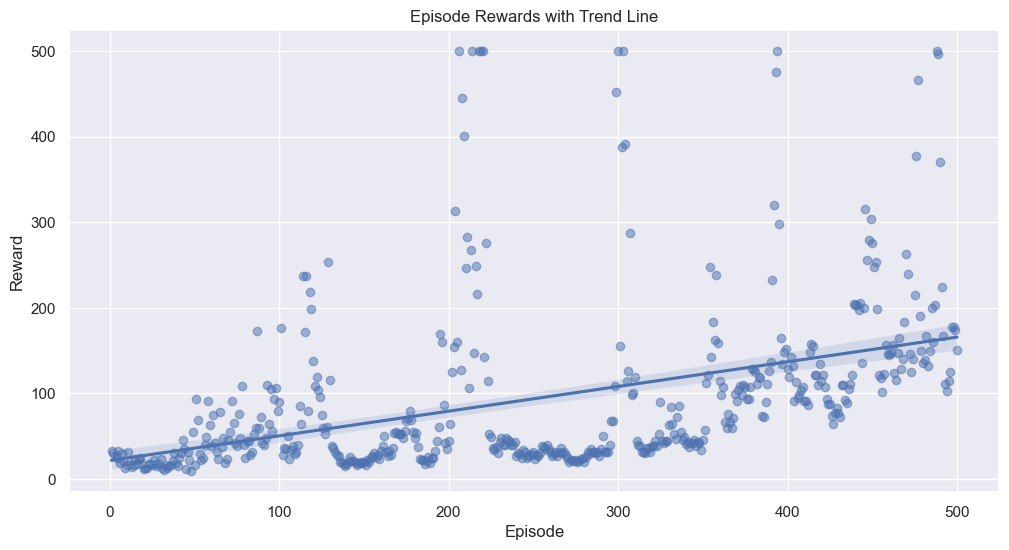

In [8]:
# Create a DataFrame for episode rewards
data = pd.DataFrame({"Episode": range(1, num_episodes + 1), "Reward": episode_rewards})

plt.figure(figsize=(12,6))
# Plot episode rewards as a scatter plot with trend line using seaborn
sns.set(style="darkgrid")
sns.regplot(data=data, x="Episode", y="Reward", scatter_kws={"alpha": 0.5})
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards with Trend Line")
plt.show()

### Test the trained agent

In [9]:
state= env.reset()
done=False
total_reward=0

while not done:
    action = actor(torch.from_numpy(state).float())
    dist = torch.distributions.Categorical(probs=action)
    action = dist.sample()
    next_state, reward, done, info = env.step(action.detach().numpy())
    state = next_state          
    # env.render()
    total_reward+=reward

print(f"Total reward: {total_reward}")
env.close()

Total reward: 152.0
